In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
df=pd.read_csv('df_jepx_spotsum.csv',usecols=[0,7])

# Ensure DATETIME is in datetime format and sort the data
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df.sort_values('DATETIME', inplace=True)

# We focus only on the SYSTEM_PRICE for the LSTM model
prices = df['SYSTEM_PRICE'].values.reshape(-1, 1)

In [5]:
df

,DATETIME,SYSTEM_PRICE
0,2005-04-02 00:00:00,6.71
1,2005-04-02 00:30:00,6.65
2,2005-04-02 01:00:00,6.39
3,2005-04-02 01:30:00,6.39
4,2005-04-02 02:00:00,5.68
...,...,...
325819,2023-11-01 21:30:00,13.91
325820,2023-11-01 22:00:00,13.14
325821,2023-11-01 22:30:00,12.75
325822,2023-11-01 23:00:00,12.60


: 

In [11]:
NP = (prices- prices.min()) / (prices.max() - prices.min())
# NP = prices/prices[0] -1 

# NP = prices

# def normalise_min_max(prices):
#     return (prices - prices.min()) / (prices.max() - prices.min())

# def standardize(df):
#     return (prices - prices.mean()) / prices.std()

In [12]:
# Function to create sequences of data points for the LSTM model
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define the sequence length (number of time steps)
sequence_length = 1 # Corresponding to 48 hours of data at 30 minute intervals

In [13]:
# Create sequences
X, y = create_sequences(NP, sequence_length)

In [14]:
len(X)

325823

In [15]:
len(y)

325823

In [16]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((228076, 1, 1), (97747, 1, 1), (228076, 1), (97747, 1))

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the LSTM model
model = Sequential()                    
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
# Due to resource limitations, we will limit the number of epochs and batch size
history = model.fit(X_train, y_train, batch_size=64, epochs=14, validation_data=(X_test, y_test))
    
# Summarize the model's architecture
model.summary()

Epoch 1/14
3564/3564 [==============================] - 65s 14ms/step - loss: 1.0026e-04 - val_loss: 6.1228e-05
Epoch 2/14
3564/3564 [==============================] - 48s 14ms/step - loss: 6.4785e-05 - val_loss: 4.8928e-05
Epoch 3/14
3564/3564 [==============================] - 46s 13ms/step - loss: 6.6522e-05 - val_loss: 4.5790e-05
Epoch 4/14
3564/3564 [==============================] - 45s 13ms/step - loss: 6.4465e-05 - val_loss: 4.5042e-05
Epoch 5/14
3564/3564 [==============================] - 46s 13ms/step - loss: 6.3626e-05 - val_loss: 4.9335e-05
Epoch 6/14
3564/3564 [==============================] - 46s 13ms/step - loss: 6.2090e-05 - val_loss: 4.4691e-05
Epoch 7/14
3564/3564 [==============================] - 48s 14ms/step - loss: 6.1235e-05 - val_loss: 6.6416e-05
Epoch 8/14
3564/3564 [==============================] - 46s 13ms/step - loss: 6.1422e-05 - val_loss: 5.6360e-05
Epoch 9/14
3564/3564 [==============================] - 46s 13ms/step - loss: 6.3467e-05 - val_loss: 5.1

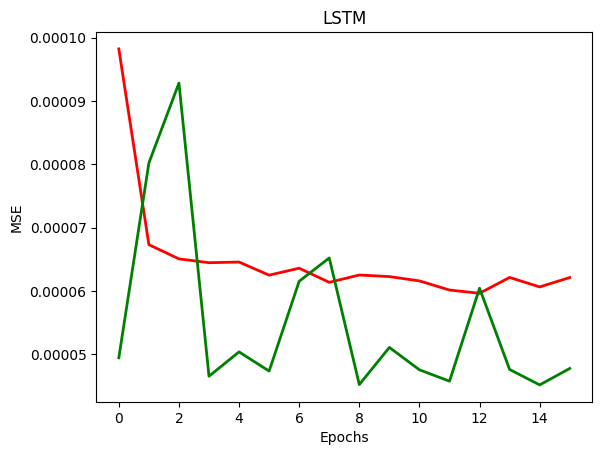

In [55]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [52]:
predicted_prices = model(X_test)

In [53]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(predicted_prices, y_test)
MSE

4.775237884489764e-05

In [54]:
from sklearn.metrics import r2_score
R2=r2_score(predicted_prices, y_test)
R2

0.9526546944526199

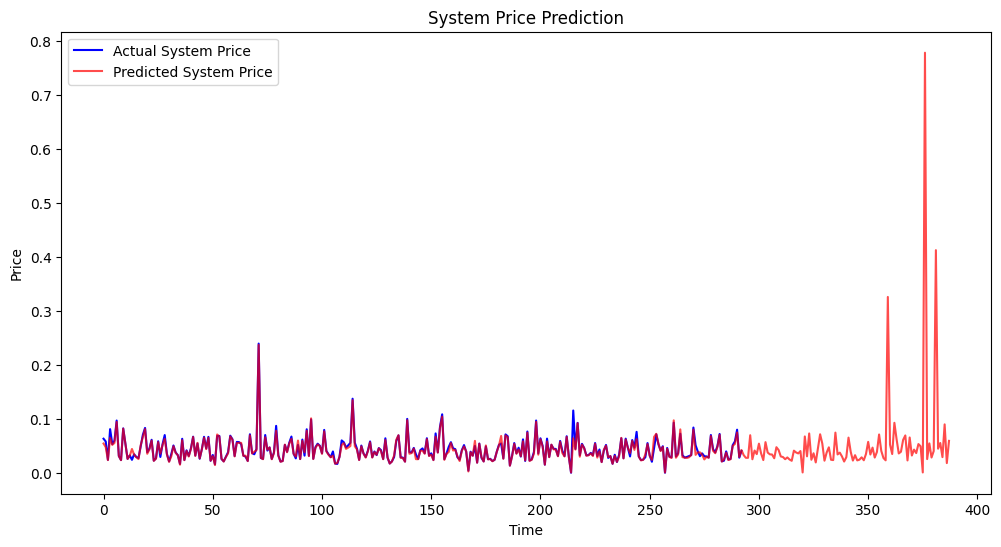

In [23]:
import matplotlib.pyplot as plt

# Plotting the actual and predicted prices
plt.figure(figsize=(12,6))
plt.plot(y_test[:293], color='blue', label='Actual System Price')
plt.plot(predicted_prices[:388], color='red', alpha=0.7, label='Predicted System Price')
plt.title('System Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()